# Описание данных
1. Unnamed: 0 - лишний безинформативный столбец
2. Year - год
3. Month - месяц
4. DayOfWeek - день недели
5. DepTime - время отправления в формате HH:MM (надо преобразовать)
6. CRSDepTime - запланированное время отправления в формате HH:MM (надо преобразовать)
7. ArrTime - время вылета в формате HH:MM (надо преобразовать)
8. CRSArrTime - запланированное время прибытия в формате HH:MM (надо преобразовать)
9. UniqueCarrier - ID оператора связи (???)
10. FlightNum - номер рейса 
11. TailNum - бортовой номер самолета
12. ActualElapsedTime - фактическое время полета в минутах
13. CRSElapsedTime - запланированное время полета в минутах
14. AirTime - время полета в воздухе в минутах
15. ArrDelay - задержка прибытия в минутах
16. Origin - аэропорт отправления
17. Dest - аэропорт назначения
18. Distance - дистанция полета
19. ??
20. ??
21. Cancelled - статус отмены (1 0)
22. CancellationCode - код отмены
23. Diverted - статус переадресации (???)
24. CarrierDelay - задержка в минутах, связанная с оператором связи
25. WeatherDelay - задержка в минутах, связанная с погодными факторами 
26. NASDelay - задержка в минутах, относящаяся к Национальной авиационной системе
27. SecurityDelay - задержка в минутах, связанная с факторами безопасности
28. LateAircraftDelay - задержка в минутах, связанная с опозданием воздушного судна

* Столбец Unnamed: 0 можно удалить сразу, никакой информации он не несет.
* Стоит преобразовать даты: сконкатенировать день, месяц и год. Учитывая, что год во всем     датасете 2008, возможно его стоит вообще удалить
* Последние столбцы с задержками можно схлопнуть в один total_factor_delay, но в них очень   много пропущенных значений, нужно оптимальным образом их заполнить (сначала попробую заполнить их медианным значением)
* Такие данные как CancellationCode, Diverted, Dest, Origin - вряд ли будут релевантны,       возможно их стоит удалить (нужно проверить) 

In [964]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [965]:
train = pd.read_csv('departure-delay2/x_train.csv')
test = pd.read_csv('departure-delay2/x_test.csv')
target = pd.read_csv('departure-delay2/y_train.csv')


In [966]:
print('Shape --->',train.shape)
print(train.info(), '\n')
print('ISNA SUM ---->\n',train.isna().sum())
train.head(5)

Shape ---> (1355730, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355730 entries, 0 to 1355729
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1355730 non-null  int64  
 1   Year               1355730 non-null  int64  
 2   Month              1355730 non-null  int64  
 3   DayofMonth         1355730 non-null  int64  
 4   DayOfWeek          1355730 non-null  int64  
 5   DepTime            1355730 non-null  float64
 6   CRSDepTime         1355730 non-null  int64  
 7   ArrTime            1350732 non-null  float64
 8   CRSArrTime         1355730 non-null  int64  
 9   UniqueCarrier      1355730 non-null  object 
 10  FlightNum          1355730 non-null  int64  
 11  TailNum            1355727 non-null  object 
 12  ActualElapsedTime  1349848 non-null  float64
 13  CRSElapsedTime     1355584 non-null  float64
 14  AirTime            1349848 non-null  float64
 15  ArrDela

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,6228008,2008,11,21,5,1500.0,1443,1557.0,1534,EV,...,7.0,16.0,0,N,0,17.0,0.0,6.0,0.0,0.0
1,4732721,2008,8,16,6,2000.0,1925,2149.0,2105,AA,...,7.0,14.0,0,N,0,31.0,0.0,9.0,0.0,4.0
2,472452,2008,1,26,6,1953.0,1900,2103.0,2020,9E,...,15.0,14.0,0,N,0,0.0,0.0,0.0,0.0,43.0
3,5300680,2008,9,15,1,1233.0,1215,1355.0,1350,AA,...,10.0,7.0,0,N,0,NaN,NaN,NaN,NaN,NaN
4,2364574,2008,4,13,7,1325.0,540,1604.0,752,CO,...,10.0,27.0,0,N,0,465.0,0.0,27.0,0.0,0.0


In [967]:
train.isna().sum().index

Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled',
       'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [968]:
print('Shape --->',test.shape)
print(test.info())
print('ISNA SUM ---->\n',test.isna().sum())
test.head(5)


Shape ---> (581028, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581028 entries, 0 to 581027
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         581028 non-null  int64  
 1   Year               581028 non-null  int64  
 2   Month              581028 non-null  int64  
 3   DayofMonth         581028 non-null  int64  
 4   DayOfWeek          581028 non-null  int64  
 5   DepTime            581028 non-null  float64
 6   CRSDepTime         581028 non-null  int64  
 7   ArrTime            578916 non-null  float64
 8   CRSArrTime         581028 non-null  int64  
 9   UniqueCarrier      581028 non-null  object 
 10  FlightNum          581028 non-null  int64  
 11  TailNum            581026 non-null  object 
 12  ActualElapsedTime  578523 non-null  float64
 13  CRSElapsedTime     580976 non-null  float64
 14  AirTime            578523 non-null  float64
 15  ArrDelay           578523 n

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,6544326,2008,12,28,7,1658.0,1645,1721.0,1720,WN,...,3.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,14847,2008,1,7,1,1933.0,1855,2032.0,2005,WN,...,5.0,10.0,0,N,0,0.0,0.0,0.0,0.0,27.0
2,3624477,2008,7,9,3,1131.0,1120,1220.0,1210,WN,...,3.0,14.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,456890,2008,1,15,2,1241.0,1208,1323.0,1300,9E,...,5.0,24.0,0,N,0,0.0,0.0,0.0,0.0,23.0
4,2861412,2008,5,22,4,1037.0,1000,1130.0,1105,9E,...,6.0,16.0,0,N,0,25.0,0.0,0.0,0.0,0.0


In [969]:
print('Shape --->',target.shape)
print(target.info())
target.head(5)

Shape ---> (1355730, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355730 entries, 0 to 1355729
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id         1355730 non-null  int64  
 1   DelayTime  1355730 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 20.7 MB
None


,id,DelayTime
0,0,17.0
1,1,35.0
2,2,53.0
3,3,18.0
4,4,465.0


In [970]:
print(x_test.shape)
x_test.head(5)

(581028, 23)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,12,28,7,1658.0,1645,1721.0,1720,1855,83.0,...,451,3.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,7,1,1933.0,1855,2032.0,2005,361,59.0,...,308,5.0,10.0,0,0,0.0,0.0,0.0,0.0,27.0
2,2008,7,9,3,1131.0,1120,1220.0,1210,111,49.0,...,159,3.0,14.0,0,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,15,2,1241.0,1208,1323.0,1300,2912,102.0,...,440,5.0,24.0,0,0,0.0,0.0,0.0,0.0,23.0
4,2008,5,22,4,1037.0,1000,1130.0,1105,5827,53.0,...,166,6.0,16.0,0,0,25.0,0.0,0.0,0.0,0.0


In [971]:
train.describe()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,1.355730e+06,1355730.0,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.350732e+06,1.355730e+06,1.355730e+06,...,1.355730e+06,1.350732e+06,1.355423e+06,1.355730e+06,1.355730e+06,872571.000000,872571.000000,872571.000000,872571.000000,872571.000000
mean,3.343270e+06,2008.0,6.113693e+00,1.574812e+01,3.984872e+00,1.518377e+03,1.467266e+03,1.610368e+03,1.634246e+03,2.184309e+03,...,7.656316e+02,6.809719e+00,1.823400e+01,3.171723e-04,4.021450e-03,19.159822,3.696012,15.020537,0.090438,25.308137
std,2.065971e+06,0.0,3.482474e+00,8.769966e+00,1.996001e+00,4.502490e+02,4.246592e+02,5.477562e+02,4.644314e+02,1.943356e+03,...,5.742785e+02,5.252686e+00,1.433670e+01,1.780651e-02,6.328729e-02,43.492431,21.551390,33.777777,2.064359,42.074585
min,0.000000e+00,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,...,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.519278e+06,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,1.203000e+03,1.135000e+03,1.316000e+03,1.325000e+03,6.100000e+02,...,3.380000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.244459e+06,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.545000e+03,1.510000e+03,1.715000e+03,1.705000e+03,1.544000e+03,...,6.060000e+02,6.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,2.000000,0.000000,2.000000,0.000000,8.000000
75%,4.974685e+06,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,1.900000e+03,1.815000e+03,2.030000e+03,2.014000e+03,3.423000e+03,...,9.980000e+02,8.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,21.000000,0.000000,15.000000,0.000000,33.000000
max,7.009727e+06,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.400000e+03,9.742000e+03,...,4.962000e+03,2.400000e+02,3.830000e+02,1.000000e+00,1.000000e+00,2436.000000,1297.000000,1357.000000,392.000000,1316.000000


In [972]:
test.describe()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,5.810280e+05,581028.0,581028.000000,581028.000000,581028.000000,581028.000000,581028.000000,578916.000000,581028.000000,581028.000000,...,581028.000000,578916.000000,580880.000000,581028.000000,581028.000000,374917.000000,374917.000000,374917.000000,374917.000000,374917.000000
mean,3.337875e+06,2008.0,6.105071,15.765961,3.984722,1518.901229,1467.954938,1609.610289,1634.175589,2184.156287,...,765.813398,6.820572,18.228002,0.000349,0.003962,19.224962,3.721162,15.024192,0.089436,25.269305
std,2.066280e+06,0.0,3.482711,8.790963,1.995887,451.036177,425.017662,549.161544,465.109149,1947.841205,...,574.949273,5.322058,14.342820,0.018688,0.062819,43.671133,21.356171,33.961395,1.922303,42.008965
min,5.000000e+00,2008.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.513340e+06,2008.0,3.000000,8.000000,2.000000,1203.000000,1135.000000,1315.000000,1325.000000,610.000000,...,338.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.237074e+06,2008.0,6.000000,16.000000,4.000000,1546.000000,1510.000000,1715.000000,1705.000000,1541.000000,...,606.000000,6.000000,14.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,8.000000
75%,4.967312e+06,2008.0,9.000000,23.000000,6.000000,1901.000000,1818.000000,2031.000000,2015.000000,3421.000000,...,997.000000,8.000000,21.000000,0.000000,0.000000,21.000000,0.000000,15.000000,0.000000,33.000000
max,7.009726e+06,2008.0,12.000000,31.000000,7.000000,2400.000000,2359.000000,2400.000000,2400.000000,9740.000000,...,4962.000000,207.000000,422.000000,1.000000,1.000000,1951.000000,1352.000000,1289.000000,216.000000,1236.000000


In [973]:
train['id'] = [i for i in range(len(train))]
train = train.merge(target, on = 'id')
x_train = train.drop(['Unnamed: 0','UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode'], axis=1)
x_test = test.drop(['Unnamed: 0','UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode'], axis=1)

In [974]:
# x_train[x_train['ArrDelay'] < 0].count()

In [975]:
# x_train = x_train.loc[x_train['ArrDelay'] > 0]
# x_test = x_test.loc[x_test['ArrDelay'] > 0]

In [976]:
x_train.isna().sum()

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                4998
CRSArrTime                0
FlightNum                 0
ActualElapsedTime      5882
CRSElapsedTime          146
AirTime                5882
ArrDelay               5882
Distance                  0
TaxiIn                 4998
TaxiOut                 307
Cancelled                 0
Diverted                  0
CarrierDelay         483159
WeatherDelay         483159
NASDelay             483159
SecurityDelay        483159
LateAircraftDelay    483159
id                        0
DelayTime                 0
dtype: int64

In [977]:
x_test.isna().sum()

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                2112
CRSArrTime                0
FlightNum                 0
ActualElapsedTime      2505
CRSElapsedTime           52
AirTime                2505
ArrDelay               2505
Distance                  0
TaxiIn                 2112
TaxiOut                 148
Cancelled                 0
Diverted                  0
CarrierDelay         206111
WeatherDelay         206111
NASDelay             206111
SecurityDelay        206111
LateAircraftDelay    206111
dtype: int64

In [978]:
x_train['CarrierDelay'].fillna(x_train['CarrierDelay'].median(), inplace = True)
x_train['WeatherDelay'].fillna(x_train['WeatherDelay'].median(), inplace = True)
x_train['NASDelay'].fillna(x_train['NASDelay'].median(), inplace = True)
x_train['SecurityDelay'].fillna(x_train['SecurityDelay'].median(), inplace = True)
x_train['LateAircraftDelay'].fillna(x_train['LateAircraftDelay'].median(), inplace = True)
x_train['ActualElapsedTime'].fillna(x_train['ActualElapsedTime'].median(), inplace = True)
x_train['CRSElapsedTime'].fillna(x_train['CRSElapsedTime'].median(), inplace = True)
x_train['AirTime'].fillna(x_train['AirTime'].median(), inplace = True)
x_train['ArrDelay'].fillna(x_train['ArrDelay'].median(), inplace = True)
x_train['TaxiIn'].fillna(x_train['TaxiIn'].median(), inplace = True)
x_train['TaxiOut'].fillna(x_train['TaxiOut'].median(), inplace = True)
x_train['ArrTime'].fillna(x_train['ArrTime'].median(), inplace = True)


x_test['CarrierDelay'].fillna(x_test['CarrierDelay'].median(), inplace = True)
x_test['WeatherDelay'].fillna(x_test['WeatherDelay'].median(), inplace = True)
x_test['NASDelay'].fillna(x_test['NASDelay'].median(), inplace = True)
x_test['SecurityDelay'].fillna(x_test['SecurityDelay'].median(), inplace = True)
x_test['LateAircraftDelay'].fillna(x_test['LateAircraftDelay'].median(), inplace = True)
x_test['ActualElapsedTime'].fillna(x_test['ActualElapsedTime'].median(), inplace = True)
x_test['CRSElapsedTime'].fillna(x_test['CRSElapsedTime'].median(), inplace = True)
x_test['AirTime'].fillna(x_test['AirTime'].median(), inplace = True)
x_test['ArrDelay'].fillna(x_test['ArrDelay'].median(), inplace = True)
x_test['TaxiIn'].fillna(x_test['TaxiIn'].median(), inplace = True)
x_test['TaxiOut'].fillna(x_test['TaxiOut'].median(), inplace = True)
x_test['ArrTime'].fillna(x_test['ArrTime'].median(), inplace = True)


x_test.isna().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
FlightNum            0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [979]:
x_train[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'ArrDelay']].describe()

,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
count,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06
mean,1.304435e+01,2.378817e+00,1.038024e+01,5.820776e-02,1.913981e+01,4.208122e+01
std,3.584692e+01,1.738014e+01,2.780672e+01,1.656713e+00,3.475759e+01,5.665260e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.090000e+02
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00
50%,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,8.000000e+00,2.400000e+01
75%,9.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.800000e+01,5.500000e+01
max,2.436000e+03,1.297000e+03,1.357000e+03,3.920000e+02,1.316000e+03,2.461000e+03


Минимальное значение ArrDelay - меньше нуля, необходимо почистить

In [980]:
x_train.isna().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
FlightNum            0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
id                   0
DelayTime            0
dtype: int64

In [981]:
x_train

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,id,DelayTime
0,2008,11,21,5,1500.0,1443,1557.0,1534,5055,117.0,...,16.0,0,0,17.0,0.0,6.0,0.0,0.0,0,17.0
1,2008,8,16,6,2000.0,1925,2149.0,2105,1043,169.0,...,14.0,0,0,31.0,0.0,9.0,0.0,4.0,1,35.0
2,2008,1,26,6,1953.0,1900,2103.0,2020,5832,70.0,...,14.0,0,0,0.0,0.0,0.0,0.0,43.0,2,53.0
3,2008,9,15,1,1233.0,1215,1355.0,1350,1501,82.0,...,7.0,0,0,2.0,0.0,2.0,0.0,8.0,3,18.0
4,2008,4,13,7,1325.0,540,1604.0,752,527,219.0,...,27.0,0,0,465.0,0.0,27.0,0.0,0.0,4,465.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355725,2008,7,7,1,945.0,925,1105.0,1045,5261,80.0,...,12.0,0,0,20.0,0.0,0.0,0.0,0.0,1355725,20.0
1355726,2008,4,11,5,1516.0,1502,1613.0,1605,1903,117.0,...,14.0,0,0,2.0,0.0,2.0,0.0,8.0,1355726,14.0
1355727,2008,2,17,7,1930.0,1920,2027.0,2020,209,57.0,...,10.0,0,0,2.0,0.0,2.0,0.0,8.0,1355727,10.0
1355728,2008,12,1,1,757.0,705,1104.0,950,1686,127.0,...,31.0,0,0,0.0,52.0,22.0,0.0,0.0,1355728,52.0


In [982]:
x_train['Total_delay'] = x_train['CarrierDelay'] + x_train['WeatherDelay'] +\
                                     x_train['NASDelay'] + x_train['SecurityDelay'] +\
                                     x_train['LateAircraftDelay']


x_test['Total_delay'] = x_test['CarrierDelay'] + x_test['WeatherDelay'] +\
                                     x_test['NASDelay'] + x_test['SecurityDelay'] +\
                                     x_test['LateAircraftDelay']


x_train['Total_delay'].describe()

count    1.355730e+06
mean     4.500143e+01
std      5.457091e+01
min      1.200000e+01
25%      1.200000e+01
50%      2.400000e+01
75%      5.500000e+01
max      2.461000e+03
Name: Total_delay, dtype: float64

In [983]:
x_test['Total_delay'].describe()

count    581028.000000
mean         45.120841
std          54.648073
min          12.000000
25%          12.000000
50%          24.000000
75%          56.000000
max        1951.000000
Name: Total_delay, dtype: float64

In [984]:
x_test.isna().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
FlightNum            0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
Total_delay          0
dtype: int64

In [985]:
x_train['Total_delay'].isna().sum() # проверка что все Nan изменены

0

<AxesSubplot:>

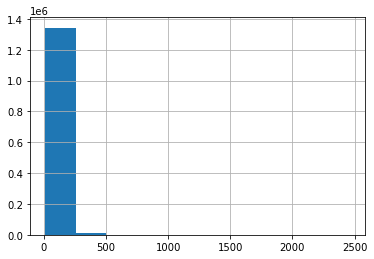

In [986]:
x_train['Total_delay'].hist()

In [987]:
print(x_train['Total_delay'].shape)
dev = (x_train['Total_delay']-x_train['Total_delay'].mean()).abs()
# Стандартное отклонение
std = x_train['Total_delay'].std()
# Фильтруем исходный набор данных
x_train = x_train[~(dev>3*std)]
#правило трех сигм для отброса выборосов
# dev_2 = (x_test['Total_delay']-x_test['Total_delay'].mean()).abs()
# std_2 = x_test['Total_delay'].std()
# x_test = x_test[~(dev_2>3*std_2)]



(1355730,)


In [988]:
x_train['Total_delay'].describe()

count    1.329341e+06
mean     4.010447e+01
std      3.916978e+01
min      1.200000e+01
25%      1.200000e+01
50%      2.300000e+01
75%      5.300000e+01
max      2.080000e+02
Name: Total_delay, dtype: float64

In [989]:
x_train['Total_delay'].isna().sum()

0

(1329341,)


<AxesSubplot:>

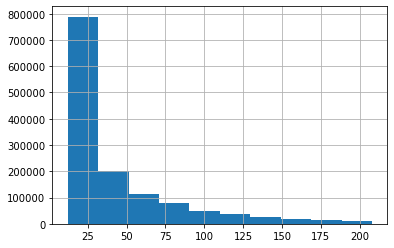

In [990]:
print(x_train['Total_delay'].shape)
x_train['Total_delay'].hist()

In [991]:
x_train.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,id,DelayTime,Total_delay
0,2008,11,21,5,1500.0,1443,1557.0,1534,5055,117.0,...,0,0,17.0,0.0,6.0,0.0,0.0,0,17.0,23.0
1,2008,8,16,6,2000.0,1925,2149.0,2105,1043,169.0,...,0,0,31.0,0.0,9.0,0.0,4.0,1,35.0,44.0
2,2008,1,26,6,1953.0,1900,2103.0,2020,5832,70.0,...,0,0,0.0,0.0,0.0,0.0,43.0,2,53.0,43.0
3,2008,9,15,1,1233.0,1215,1355.0,1350,1501,82.0,...,0,0,2.0,0.0,2.0,0.0,8.0,3,18.0,12.0
5,2008,8,29,5,1704.0,1555,1903.0,1730,4723,119.0,...,0,0,17.0,0.0,24.0,0.0,52.0,5,69.0,93.0


<AxesSubplot:xlabel='DayOfWeek'>

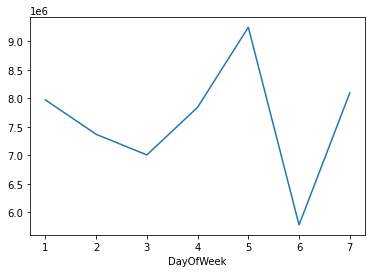

In [992]:
x_train.groupby('DayOfWeek')['Total_delay'].sum().plot()

In [993]:
x_train.groupby('Cancelled')['Total_delay'].sum()
#после чистки остались только неотмененные рейсы, удаляем стоблец Cancelled

Cancelled
0    53307359.0
1        5160.0
Name: Total_delay, dtype: float64

In [994]:
x_train.drop('Cancelled', axis = 1, inplace = True)

x_test.drop('Cancelled', axis = 1, inplace = True)

/Users/jokkojja/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [995]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329341 entries, 0 to 1355729
Data columns (total 25 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Year               1329341 non-null  int64  
 1   Month              1329341 non-null  int64  
 2   DayofMonth         1329341 non-null  int64  
 3   DayOfWeek          1329341 non-null  int64  
 4   DepTime            1329341 non-null  float64
 5   CRSDepTime         1329341 non-null  int64  
 6   ArrTime            1329341 non-null  float64
 7   CRSArrTime         1329341 non-null  int64  
 8   FlightNum          1329341 non-null  int64  
 9   ActualElapsedTime  1329341 non-null  float64
 10  CRSElapsedTime     1329341 non-null  float64
 11  AirTime            1329341 non-null  float64
 12  ArrDelay           1329341 non-null  float64
 13  Distance           1329341 non-null  int64  
 14  TaxiIn             1329341 non-null  float64
 15  TaxiOut            1329341 non-n

In [996]:
def getTime(t):
    if len(t) == 4:
        
        if t == "2400":
            t = "0000"
            
        t = t + '00' 
        return t[:2] + ':' + t[2:4] + ':' + t[4:]
    elif len(t) == 3:
    
        t = '0' + t + '00'
        return t[:2] + ':' + t[2:4] + ':' + t[4:]
    

In [1001]:
reg = LinearRegression()
reg.fit(x_train, target)

LinearRegression()

In [1002]:
prediction = reg.predict(x_test)

In [1005]:
prediction

array([ 14.33768156,  36.414762  ,  11.62776387, ...,  15.12889727,
       109.06065729,  46.06070454])

In [1006]:
pd.Series(prediction, name='DelayTime').to_csv('prediction.csv', index_label='id', header=True)
test = pd.read_csv('prediction.csv')
test

,id,DelayTime
0,0,14.337682
1,1,36.414762
2,2,11.627764
3,3,30.230515
4,4,34.202570
...,...,...
581023,581023,82.650364
581024,581024,24.539225
581025,581025,15.128897
581026,581026,109.060657


In [854]:
X_train, X_test, y_train, y_test = train_test_split(x_train, target)
# dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10000, min_samples_split=10000)
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
pred

array([20.61409931, 13.40223298,  9.80662031, ..., 12.79732755,
       16.5654943 , 54.6715655 ])

In [855]:
mean_squared_error(pred, y_test)

132.72423910677168

In [858]:
prediction = dt.predict(x_test)

In [860]:
pd.Series(prediction, name='DelayTime').to_csv('tree_prediction.csv', index_label='id', header=True)
test = pd.read_csv('tree_prediction.csv')
test

,id,DelayTime
0,0,13.229681
1,1,31.812290
2,2,14.261175
3,3,28.037536
4,4,31.812290
...,...,...
581023,581023,54.508615
581024,581024,30.206188
581025,581025,20.019040
581026,581026,113.619822
